<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/RAFT/RAFT_deep_dive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAFT Deep Dive**

## NOTE: GPU is required for this tutorial

Get RAFT and RAFT helper script

In [1]:
!git clone https://github.com/princeton-vl/RAFT.git

Cloning into 'RAFT'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 147 (delta 0), reused 2 (delta 0), pack-reused 144
Receiving objects: 100% (147/147), 10.01 MiB | 15.21 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [1]:
!wget https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/raft_utils.py

--2023-09-15 00:26:22--  https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/raft_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2203 (2.2K) [text/plain]
Saving to: ‘raft_utils.py’

raft_utils.py       100%[===================>]   2.15K  --.-KB/s    in 0s      

2023-09-15 00:26:22 (35.5 MB/s) - ‘raft_utils.py’ saved [2203/2203]



In [5]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from raft_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# add RAFT to core path
sys.path.append('RAFT/core')

In [ ]:
# download models
%cd RAFT
!./download_models.sh
%cd ..

### Test Run RAFT

In [6]:
demo_path = 'RAFT/demo-frames'
frame1 = cv2.imread(os.path.join(demo_path, 'frame_0020.png'))
frame2 = cv2.imread(os.path.join(demo_path, 'frame_0021.png'))

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

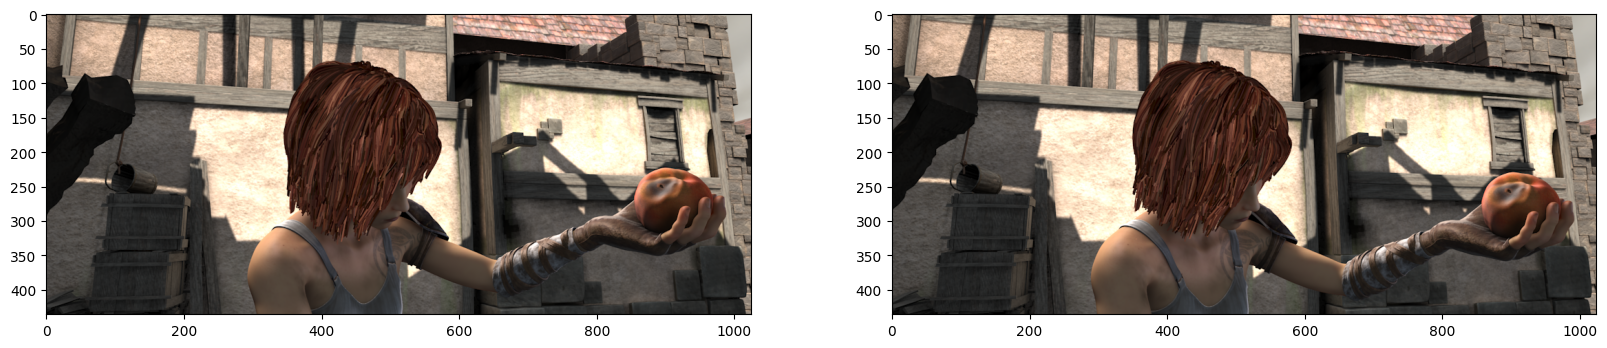

In [10]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(frame1)
ax[1].imshow(frame2);

In [7]:
# load model
model = load_model("RAFT/models/raft-sintel.pth", args=Args())

# predict Optical Flow
flow_iters = inference(model, frame1, frame2, device='cuda', test_mode=False)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


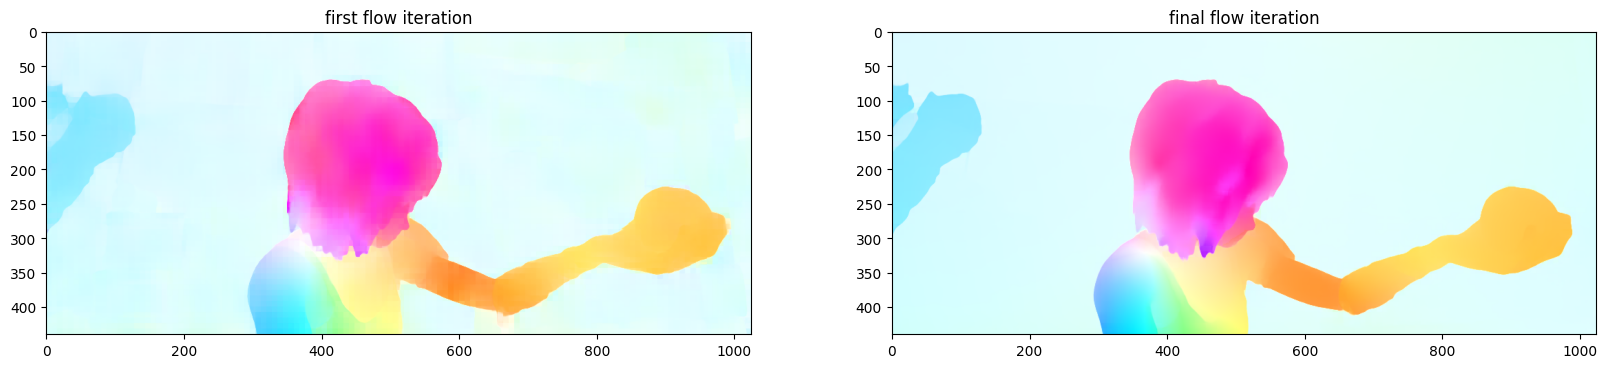

In [8]:
_, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_iters[0]))
ax0.set_title('first flow iteration')
ax1.imshow(get_viz(flow_iters[-1]))
ax1.set_title('final flow iteration');

Get final optical flow iteration and find some pixels of interest i.e. pixels with high flow and pixels with low flow

In [54]:
flow = flow_iters[-1].squeeze(0).cpu().numpy()
abs_flow = np.abs(flow)
flow.shape

(2, 440, 1024)

In [75]:
# highest abs flow in each direction
hi_flow_1 = np.where(abs_flow == abs_flow[0, :, :].max()) # u - horizontal
hi_flow_2 = np.where(abs_flow == abs_flow[1, :, :].max()) # v - vertical

# lowest abs flow in each direction
lo_flow_1 = np.where(abs_flow == abs_flow[0, :, :].min()) # u - horizontal
lo_flow_2 = np.where(abs_flow == abs_flow[1, :, :].min()) # v - vertical

In [76]:
flow[lo_flow_1], flow[lo_flow_2], flow[hi_flow_1], flow[hi_flow_2]

(array([3.5241246e-05], dtype=float32),
 array([2.0321459e-06], dtype=float32),
 array([-10.756658], dtype=float32),
 array([-8.542325], dtype=float32))

# **Explore Different Blocks of RAFT**

First preprocess the data

In [77]:
demo_path = 'RAFT/demo-frames'
frame1 = cv2.imread(os.path.join(demo_path, 'frame_0020.png'))
frame2 = cv2.imread(os.path.join(demo_path, 'frame_0021.png'))

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)


# neural net processing
frame1 = process_img(frame1, device='cuda')
frame2 = process_img(frame2, device='cuda')

padder = InputPadder(frame1.shape, mode='sintel')
frame1, frame2 = padder.pad(frame1, frame2)

frame1 = 2 * (frame1 / 255.0) - 1.0
frame2 = 2 * (frame2 / 255.0) - 1.0

frame1 = frame1.contiguous()
frame2 = frame2.contiguous()

## **Explore the Correlation Block**

In [78]:
from corr import CorrBlock

# compute feature maps
with torch.autocast(device_type='cuda', enabled=True):
    fmap1, fmap2 = model.module.fnet([frame1, frame2])

fmap1 = fmap1.float()
fmap2 = fmap2.float()

# compute correlation pyramid
corr_fn = CorrBlock(fmap1, fmap2, num_levels=4, radius=4)

In [79]:
# check sizes of correlation pyramid
print(frame1.shape)
cov_mats = []
for i in range(4):
  print(corr_fn.corr_pyramid[i].shape)
  cov_mats.append(np.cov(corr_fn.corr_pyramid[i].detach().cpu().numpy().reshape((7040, -1), order='c'), rowvar=False))

torch.Size([1, 3, 440, 1024])
torch.Size([7040, 1, 55, 128])
torch.Size([7040, 1, 27, 64])
torch.Size([7040, 1, 13, 32])
torch.Size([7040, 1, 6, 16])


From this print out we can see that each fine pixel (from frame 1) has a corresponding feature map. As we go up the pyramid, we can see that these feature maps get smaller due to the average pooling operation. The average pooling operation should also introduce correlations. For example in the first level (no pooling) each pixel from frame 2 corresponds to a single pixel from frame 1. In the second level, each pixel from frame 2 will correspond to four pixels in frame 1 and so fourth. So we are essentially introducing greater and greater spatial correlations by average pooling the last two dimensions of the correlation volume

In [80]:
corr_fn.corr_pyramid[i].detach().cpu().numpy().reshape((7040, -1)).shape

(7040, 96)

At this point we want to visualize how each the feature maps that correspond to each fine pixel of frame 1 vary with eachother. At each level we will have 7040 samples of each feature map, we want to see how each of these feature maps is related

In [81]:
normed_covs = []
for c in cov_mats:
    normed_covs.append(cv2.normalize(c, dst=None, alpha=0.00001, beta=1.00001, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))

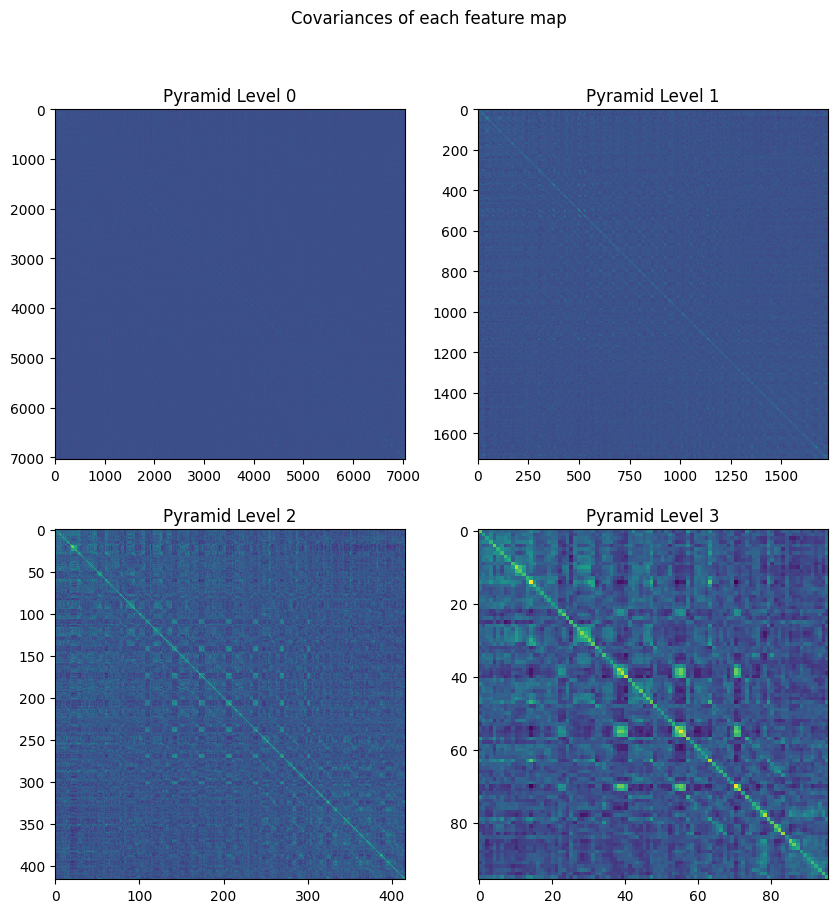

In [82]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Covariances of each feature map")
ax[0, 0].imshow(normed_covs[0])
ax[0, 0].set_title("Pyramid Level 0")
ax[0, 1].imshow(normed_covs[1])
ax[0, 1].set_title("Pyramid Level 1")
ax[1, 0].imshow(normed_covs[2])
ax[1, 0].set_title("Pyramid Level 2")
ax[1, 1].imshow(normed_covs[3])
ax[1, 1].set_title("Pyramid Level 3");

Eventhough we can see the strong cross correlations of the higher feature maps, the displayed covariances of each feature map aren't too helpful for this purpose. Let's look at the middle pixel of each pyramid and see how it relates to the surrounding pixels. To do this, we will just index the middel pixel row of each covariance matrix and plot the columns.

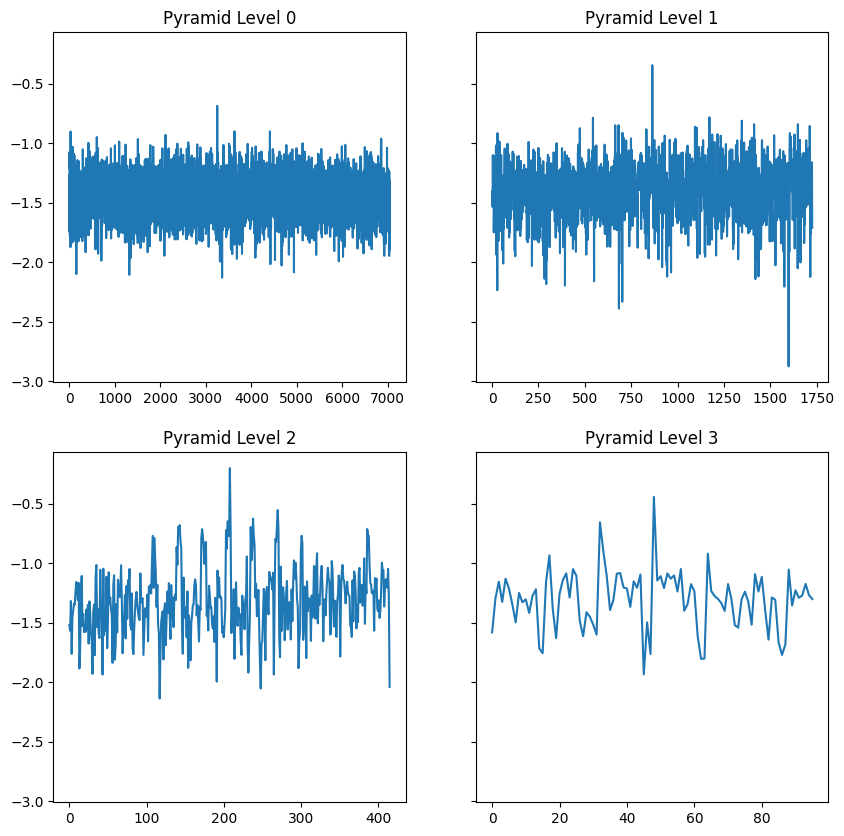

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
ax[0, 0].plot(np.log(normed_covs[0][3250, :]))
ax[0, 0].set_title("Pyramid Level 0")
ax[0, 1].plot(np.log(normed_covs[1][864, :]))
ax[0, 1].set_title("Pyramid Level 1")
ax[1, 0].plot(np.log(normed_covs[2][208, :]))
ax[1, 0].set_title("Pyramid Level 2")
ax[1, 1].plot(np.log(normed_covs[3][48, :]))
ax[1, 1].set_title("Pyramid Level 3");

We can see at level 0 (no pooling and no correlations) that there is a single spike (self-correlation) but the remaining pixels are just noise). there is a similar relationship at pyramid level 1 (1 avg pool). However, at levels 2 and 3 we can start to see some rolloff from the center, indicating that the middle pixel has relationships with it's surrounding pixels.

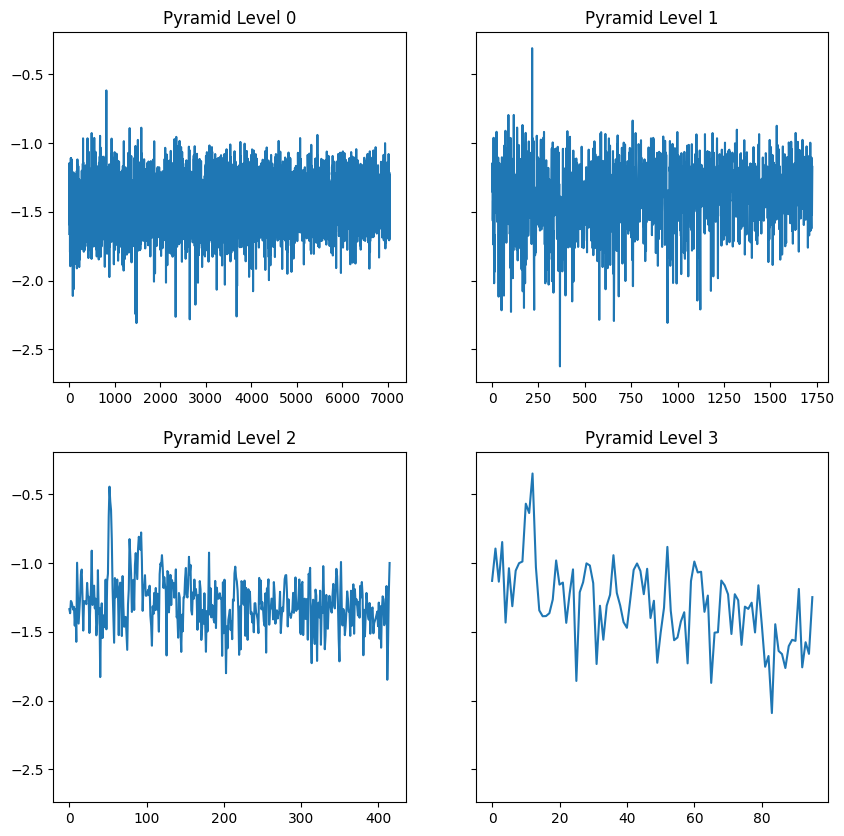

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
ax[0, 0].plot(np.log(normed_covs[0][813, :]))
ax[0, 0].set_title("Pyramid Level 0")
ax[0, 1].plot(np.log(normed_covs[1][216, :]))
ax[0, 1].set_title("Pyramid Level 1")
ax[1, 0].plot(np.log(normed_covs[2][52, :]))
ax[1, 0].set_title("Pyramid Level 2")
ax[1, 1].plot(np.log(normed_covs[3][12, :]))
ax[1, 1].set_title("Pyramid Level 3");

Initialize the flow

In [138]:
# returns a mesh grid tensor at 1/8 the sizee of the input frame
coords0, coords1 = model.module.initialize_flow(frame1)

## **Explore Correlation Look Up Operator**
#### Go through code to index correlation volume

In [139]:
r = 4 # radius
coords = coords1.detach().permute(0, 2, 3, 1)
batch, h1, w1, _ = coords.shape
out_pyramid = []

In [140]:
i = 0
_corr = corr_fn.corr_pyramid[i]
dx = torch.linspace(-r, r, 2*r+1, device=coords.device)
dy = torch.linspace(-r, r, 2*r+1, device=coords.device)
delta = torch.stack(torch.meshgrid(dy, dx), axis=-1)

In [141]:
dx, dy, delta.shape

(tensor([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.], device='cuda:0'),
 tensor([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.], device='cuda:0'),
 torch.Size([9, 9, 2]))

In [142]:
centroid_lvl = coords.reshape(batch*h1*w1, 1, 1, 2) / 2**i
delta_lvl = delta.view(1, 2*r+1, 2*r+1, 2)
coords_lvl = centroid_lvl + delta_lvl

In [143]:
centroid_lvl[1, :, :, :]

tensor([[[1., 0.]]], device='cuda:0')

In [144]:
centroid_lvl.shape, delta_lvl.shape, coords_lvl.shape

(torch.Size([7040, 1, 1, 2]),
 torch.Size([1, 9, 9, 2]),
 torch.Size([7040, 9, 9, 2]))

In [145]:
centroid_lvl[10, :, :, :]

tensor([[[10.,  0.]]], device='cuda:0')

#### Set Exploration Index

In [158]:
lo_flow_1

(array([0]), array([322]), array([373]))

In [147]:
frame1.shape

torch.Size([1, 3, 440, 1024])

In [148]:
1024/8

128.0

In [159]:
322/8, 373/8

(40.25, 46.625)

In [298]:
def get_corr_idx(loc):
    u = np.clip(np.round(loc[2]/8), 0, 127)
    v = np.clip(np.round(loc[1]/8), 0, 54)
    return int(u + 128*v)

In [299]:
flow.shape

(2, 440, 1024)

In [300]:
hi_flow_1

(array([0]), array([439]), array([343]))

In [301]:
hi_flow_2

(array([1]), array([320]), array([456]))

In [302]:
439/8, 343/8

(54.875, 42.875)

In [303]:
40 + 57*128

7336

In [304]:
43 + 128*55

7083

In [305]:
centroid_lvl.shape

torch.Size([7040, 1, 1, 2])

In [306]:
get_corr_idx(hi_flow_2)

5177

In [307]:
57 + 128*40

5177

In [358]:
flow.shape

(2, 440, 1024)

In [308]:
hi_flow_2

(array([1]), array([320]), array([456]))

In [309]:
439/8, 343/8

(54.875, 42.875)

In [310]:
get_corr_idx(hi_flow_1)

6955

In [385]:
idx = get_corr_idx(lo_flow_1)

pixel_loc = centroid_lvl[idx, :, :, :].cpu().numpy().squeeze()
pixel_loc

array([47., 40.], dtype=float32)

In [386]:
idx

5167

In [387]:
coords_lvl[idx, :, :, 0],coords_lvl[idx, :, :, 1]

(tensor([[43., 43., 43., 43., 43., 43., 43., 43., 43.],
         [44., 44., 44., 44., 44., 44., 44., 44., 44.],
         [45., 45., 45., 45., 45., 45., 45., 45., 45.],
         [46., 46., 46., 46., 46., 46., 46., 46., 46.],
         [47., 47., 47., 47., 47., 47., 47., 47., 47.],
         [48., 48., 48., 48., 48., 48., 48., 48., 48.],
         [49., 49., 49., 49., 49., 49., 49., 49., 49.],
         [50., 50., 50., 50., 50., 50., 50., 50., 50.],
         [51., 51., 51., 51., 51., 51., 51., 51., 51.]], device='cuda:0'),
 tensor([[36., 37., 38., 39., 40., 41., 42., 43., 44.],
         [36., 37., 38., 39., 40., 41., 42., 43., 44.],
         [36., 37., 38., 39., 40., 41., 42., 43., 44.],
         [36., 37., 38., 39., 40., 41., 42., 43., 44.],
         [36., 37., 38., 39., 40., 41., 42., 43., 44.],
         [36., 37., 38., 39., 40., 41., 42., 43., 44.],
         [36., 37., 38., 39., 40., 41., 42., 43., 44.],
         [36., 37., 38., 39., 40., 41., 42., 43., 44.],
         [36., 37., 38., 39.,

In [388]:
xi0, xi1 = coords_lvl[idx, 0, 0, 0].cpu().numpy(), coords_lvl[idx, -1, 0, 0].cpu().numpy() + 1
yi0, yi1 = coords_lvl[idx, 0, 0, 1].cpu().numpy(), coords_lvl[idx, 0, -1, 1].cpu().numpy() + 1

xi0, xi1 = int(np.clip(xi0, 0, np.infty)), int(np.clip(xi1, 0, np.infty))
yi0, yi1 = int(np.clip(yi0, 0, np.infty)), int(np.clip(yi1, 0, np.infty))

# xi0, xi1 = int(xi0), int(xi1)
# yi0, yi1 = int(yi0), int(yi1)

xi0, xi1, yi0, yi1

(43, 52, 36, 45)

Sample from the correlation response at each fine pixel

In [389]:
from RAFT.core.utils.utils import bilinear_sampler

corr = bilinear_sampler(_corr, coords_lvl)

In [390]:
corr.shape, _corr.shape, coords_lvl.shape

(torch.Size([7040, 1, 9, 9]),
 torch.Size([7040, 1, 55, 128]),
 torch.Size([7040, 9, 9, 2]))

### Plot Results

In [391]:
# get RGB correlation response for display
corr_response = _corr[idx, 0, :, :].detach().cpu().numpy()
# corr_response = cv2.normalize(corr_response, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
# corr_response = np.dstack((corr_response, corr_response, corr_response))

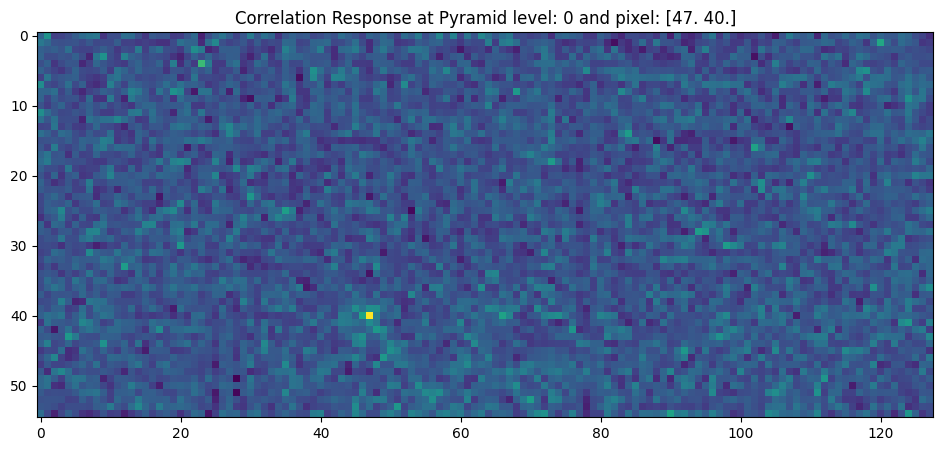

In [396]:
import matplotlib.patches as patches

_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(corr_response);
ax.set_title(f"Correlation Response at Pyramid level: {i} and pixel: {pixel_loc}");

# mark I2 pixel under test
rect = patches.Rectangle(pixel_loc - 0.5, 1, 1, linewidth=2, edgecolor='r', facecolor='none')
# ax.add_patch(rect)

plt.show();

In [393]:
corr_response.min(), corr_response.max(), corr_response.mean(), np.median(corr_response), corr_response.sum()

(-4.032708, 10.8050785, -0.03897593, -0.122917265, -274.39056)

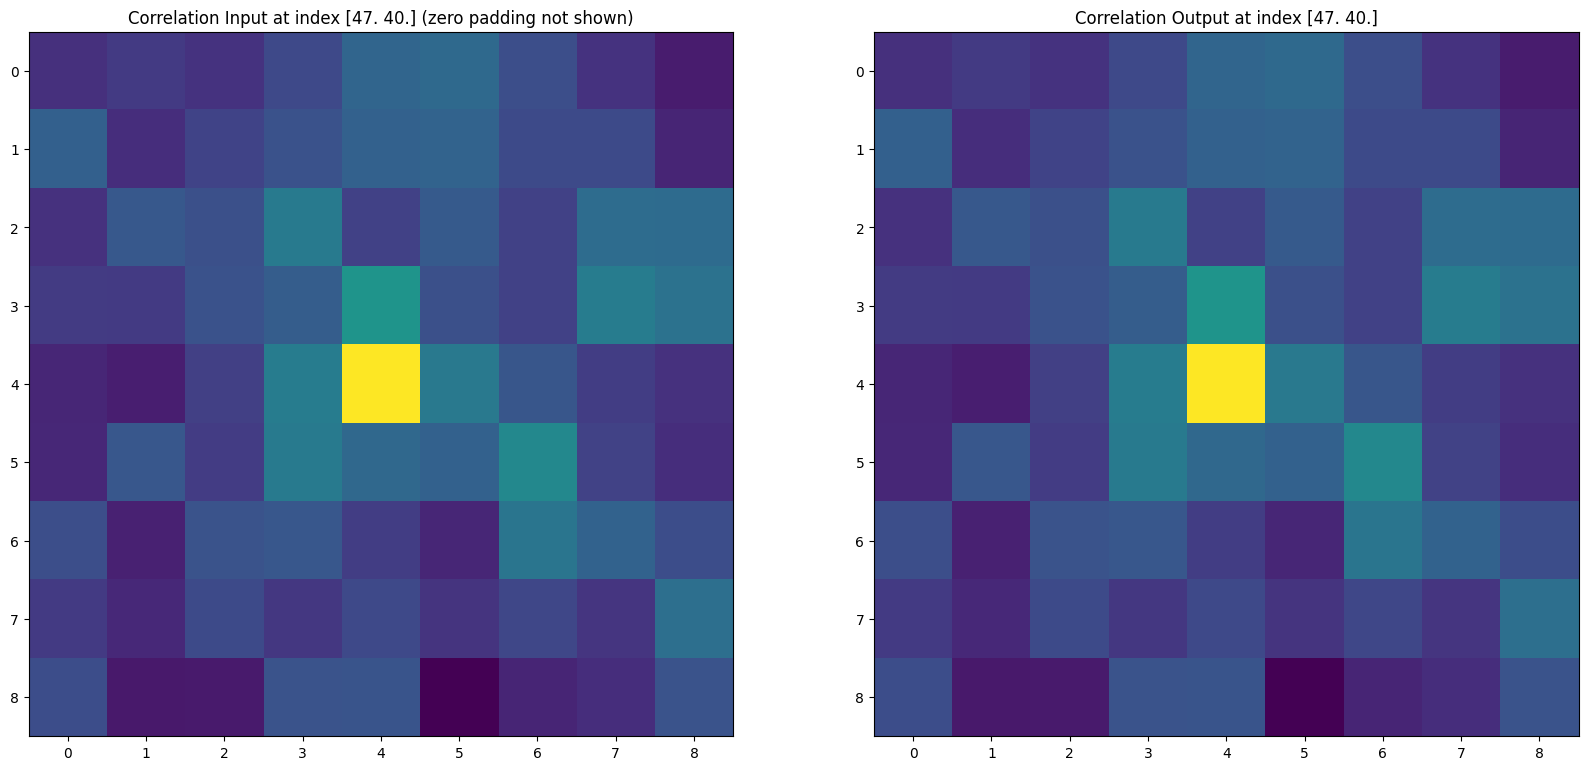

In [395]:
_, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

# ax0.imshow(_corr[idx, 0, 19:28, 52:61].detach().cpu().numpy().T)
# ax0.set_title(f"Correlation Input at index {idx}")
# ax1.imshow(corr[idx, 0, :, :].detach().cpu().numpy())
# ax1.set_title(f"Correlation Output at index {idx}");

# ensure orientations are consistentidx
# input_corr = _corr[idx, 0, yi0:yi1, xi0:xi1].detach().cpu().numpy()
# output_corr = corr[idx, 0, :, :].detach().cpu().numpy().T

input_corr = _corr[idx, 0, yi0:yi1, xi0:xi1].detach().cpu().numpy().T
output_corr = corr[idx, 0, :, :].detach().cpu().numpy()

ax0.imshow(input_corr)
ax0.set_title(f"Correlation Input at index {pixel_loc} (zero padding not shown)")
ax1.imshow(output_corr)
ax1.set_title(f"Correlation Output at index {pixel_loc}");

Manually Inspect results

In [325]:
np.round(input_corr, 2), np.round(output_corr, 2)

(array([[ 1.83,  3.03,  3.9 ,  2.05,  2.45],
        [ 0.19,  0.07,  0.97,  0.21, -0.31],
        [-0.72, -0.39, -0.29,  0.77,  5.29],
        [ 0.47,  1.1 , -0.62,  0.6 ,  5.87],
        [ 2.95,  0.36, -0.34, -0.74, -0.31],
        [ 1.23, -0.72, -0.24,  0.63,  1.15],
        [ 0.73,  2.98,  1.02, -0.08, -1.13],
        [-2.75, -2.1 , -0.1 ,  0.51, -0.79],
        [-0.39, -0.19,  0.31,  1.29,  0.87]], dtype=float32),
 array([[ 1.83,  3.03,  3.9 ,  2.05,  2.45,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.19,  0.07,  0.97,  0.21, -0.31,  0.  ,  0.  ,  0.  ,  0.  ],
        [-0.72, -0.39, -0.29,  0.77,  5.29,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.47,  1.1 , -0.62,  0.6 ,  5.87,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 2.95,  0.36, -0.34, -0.74, -0.31,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 1.23, -0.72, -0.24,  0.63,  1.15,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.73,  2.98,  1.02, -0.08, -1.13,  0.  ,  0.  ,  0.  ,  0.  ],
        [-2.75, -2.1 , -0.1 ,  0.51, -0.79,  0.  ,  0.  ,  0.  ,  0

In [326]:
_corr[idx, 0, :, :].max(), corr[idx, 0, :, :].max()

(tensor(6.0269, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(5.8745, device='cuda:0', grad_fn=<MaxBackward1>))

In [327]:
torch.where(_corr[idx, 0, :, :] == _corr[idx, 0, :, :].max()), torch.where(corr[idx, 0, :, :] == corr[idx, 0, :, :].max())

((tensor([2], device='cuda:0'), tensor([42], device='cuda:0')),
 (tensor([3], device='cuda:0'), tensor([4], device='cuda:0')))

In [328]:
_corr.shape, coords_lvl.shape

(torch.Size([7040, 1, 55, 128]), torch.Size([7040, 9, 9, 2]))

In [329]:
# _corr, coords_lvl

H, W = _corr.shape[-2:]
xgrid, ygrid = coords_lvl.split([1,1], dim=-1)
xgrid = 2*xgrid/(W-1) - 1
ygrid = 2*ygrid/(H-1) - 1

In [330]:
xgrid.shape, ygrid.shape, coords_lvl.shape

(torch.Size([7040, 9, 9, 1]),
 torch.Size([7040, 9, 9, 1]),
 torch.Size([7040, 9, 9, 2]))

In [331]:
xgrid[idx, :, :].squeeze()

tensor([[-0.3858, -0.3858, -0.3858, -0.3858, -0.3858, -0.3858, -0.3858, -0.3858,
         -0.3858],
        [-0.3701, -0.3701, -0.3701, -0.3701, -0.3701, -0.3701, -0.3701, -0.3701,
         -0.3701],
        [-0.3543, -0.3543, -0.3543, -0.3543, -0.3543, -0.3543, -0.3543, -0.3543,
         -0.3543],
        [-0.3386, -0.3386, -0.3386, -0.3386, -0.3386, -0.3386, -0.3386, -0.3386,
         -0.3386],
        [-0.3228, -0.3228, -0.3228, -0.3228, -0.3228, -0.3228, -0.3228, -0.3228,
         -0.3228],
        [-0.3071, -0.3071, -0.3071, -0.3071, -0.3071, -0.3071, -0.3071, -0.3071,
         -0.3071],
        [-0.2913, -0.2913, -0.2913, -0.2913, -0.2913, -0.2913, -0.2913, -0.2913,
         -0.2913],
        [-0.2756, -0.2756, -0.2756, -0.2756, -0.2756, -0.2756, -0.2756, -0.2756,
         -0.2756],
        [-0.2598, -0.2598, -0.2598, -0.2598, -0.2598, -0.2598, -0.2598, -0.2598,
         -0.2598]], device='cuda:0')

In [332]:
ygrid[idx, :, :].squeeze()

tensor([[0.8519, 0.8889, 0.9259, 0.9630, 1.0000, 1.0370, 1.0741, 1.1111, 1.1481],
        [0.8519, 0.8889, 0.9259, 0.9630, 1.0000, 1.0370, 1.0741, 1.1111, 1.1481],
        [0.8519, 0.8889, 0.9259, 0.9630, 1.0000, 1.0370, 1.0741, 1.1111, 1.1481],
        [0.8519, 0.8889, 0.9259, 0.9630, 1.0000, 1.0370, 1.0741, 1.1111, 1.1481],
        [0.8519, 0.8889, 0.9259, 0.9630, 1.0000, 1.0370, 1.0741, 1.1111, 1.1481],
        [0.8519, 0.8889, 0.9259, 0.9630, 1.0000, 1.0370, 1.0741, 1.1111, 1.1481],
        [0.8519, 0.8889, 0.9259, 0.9630, 1.0000, 1.0370, 1.0741, 1.1111, 1.1481],
        [0.8519, 0.8889, 0.9259, 0.9630, 1.0000, 1.0370, 1.0741, 1.1111, 1.1481],
        [0.8519, 0.8889, 0.9259, 0.9630, 1.0000, 1.0370, 1.0741, 1.1111, 1.1481]],
       device='cuda:0')

## **Explore the Recurrent Update Block**

In [333]:
hdim = model.module.hidden_dim
cdim = model.module.context_dim

with torch.autocast(device_type='cuda', enabled=True):
    cnet = model.module.cnet(frame1)
    net, inp = torch.split(cnet, [hdim, cdim], dim=1)
    net = torch.tanh(net)
    inp = torch.relu(inp)

## Compare Learned Feature maps to the context features

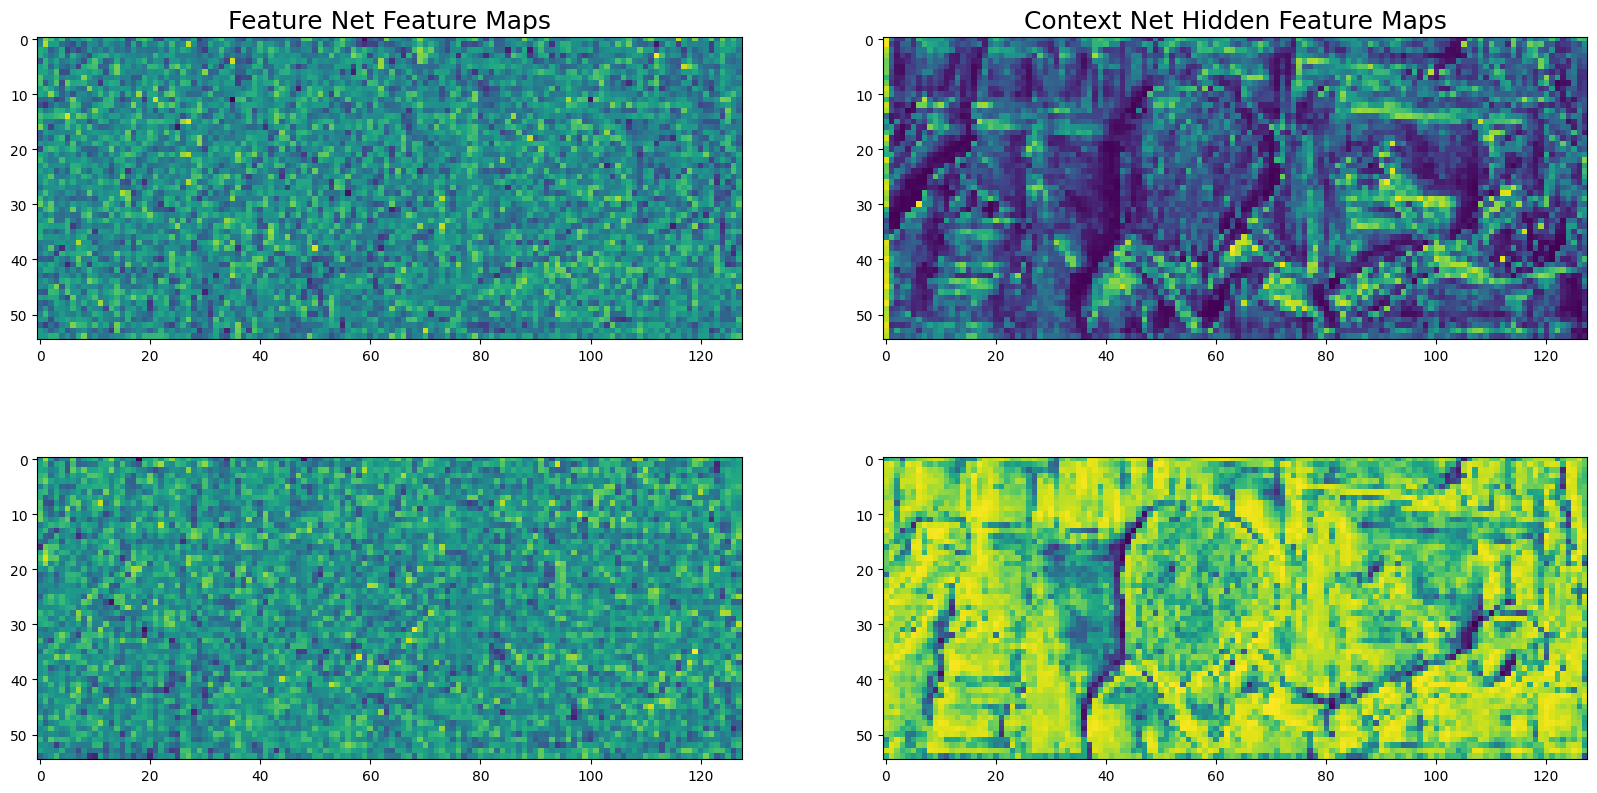

In [334]:
_, (ax0, ax1) = plt.subplots(2, 2, figsize=(20,10))
ax0[0].imshow(fmap1.squeeze(0)[0, :, :].detach().cpu().numpy())
ax0[0].set_title("Feature Net Feature Maps", size=18)

ax0[1].imshow(net.squeeze(0)[0, :, :].detach().cpu().numpy())
ax0[1].set_title("Context Net Hidden Feature Maps", size=18)

ax1[0].imshow(fmap1.squeeze(0)[10, :, :].detach().cpu().numpy())

ax1[1].imshow(net.squeeze(0)[10, :, :].detach().cpu().numpy());

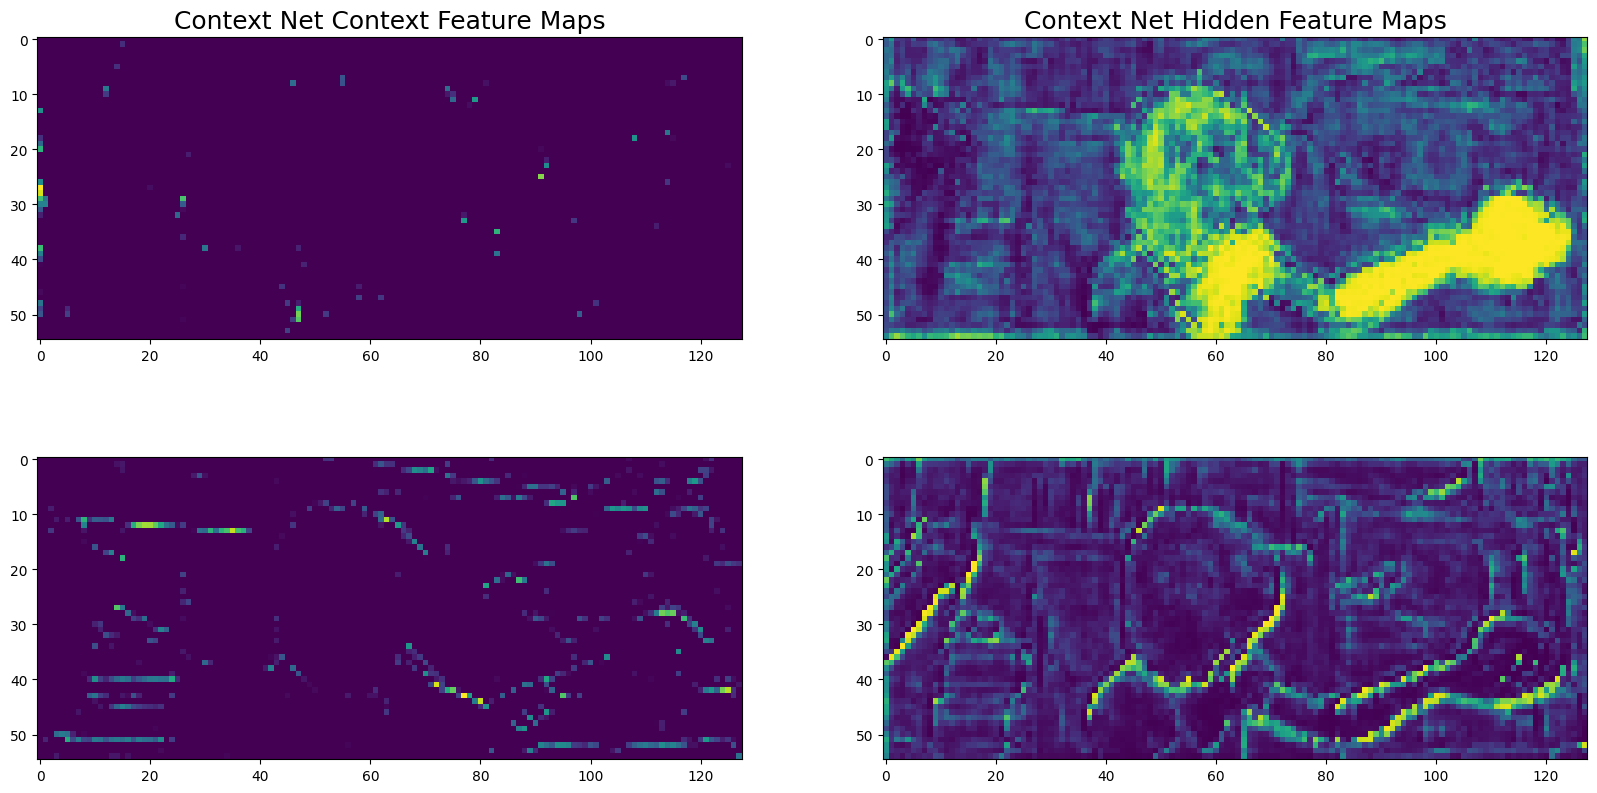

In [ ]:
_, (ax0, ax1) = plt.subplots(2, 2, figsize=(20,10))
ax0[0].imshow(inp.squeeze(0)[20, :, :].detach().cpu().numpy())
ax0[0].set_title("Context Net Context Feature Maps", size=18)

ax0[1].imshow(net.squeeze(0)[20, :, :].detach().cpu().numpy())
ax0[1].set_title("Context Net Hidden Feature Maps", size=18)

ax1[0].imshow(inp.squeeze(0)[120, :, :].detach().cpu().numpy())

ax1[1].imshow(net.squeeze(0)[120, :, :].detach().cpu().numpy());

In [ ]:
inp.max(), net.max()

(tensor(4.9297, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>),
 tensor(1., device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

Since the network uses the hidden maps as the optical flow output, it makes sense for the context network to decode hidden feature maps that emphasize different aspects of the input image.

We can see that the feature extraction network learns something super abstract, while

In [ ]:
# initialize flow
coords0, coords1 = model.module.initialize_flow(frame1)

In [ ]:
coords1 = coords1.detach()
corr = corr_fn(coords1) # index correlation volume

flow = coords1 - coords0
with torch.autocast(device_type='cuda', enabled=True):
    net, up_mask, delta_flow = model.module.update_block(net, inp, corr, flow)



In [ ]:
net.shape, delta_flow.shape

(torch.Size([1, 128, 55, 128]), torch.Size([1, 2, 55, 128]))

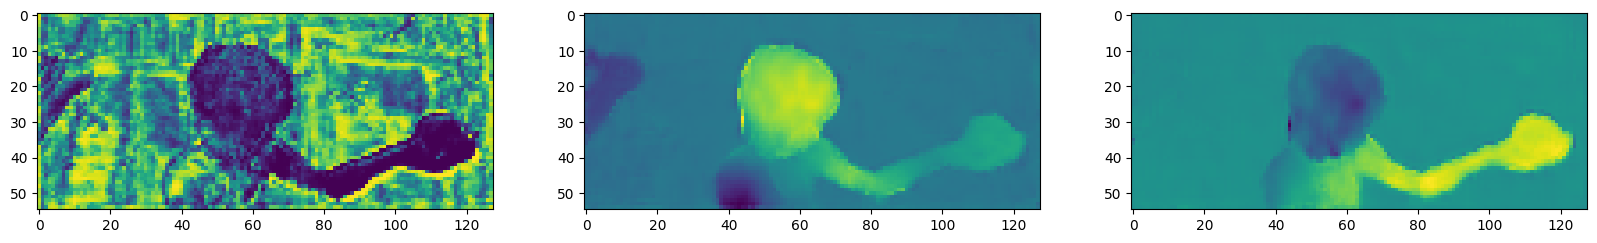

In [ ]:
_, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,10))
ax0.imshow(net.squeeze(0)[0, :, :].detach().cpu().numpy())
ax1.imshow(delta_flow.squeeze(0)[0, :, :].detach().cpu().numpy())
ax2.imshow(delta_flow.squeeze(0)[1, :, :].detach().cpu().numpy())

In [ ]:
# F(t+1) = F(t) + \Delta(t)
coords1 = coords1 + delta_flow

## **Re-Explore the Correlation using the new flow estimate**

In [ ]:
r = 4 # radius
coords = coords1.detach().permute(0, 2, 3, 1)
batch, h1, w1, _ = coords.shape
out_pyramid = []

In [ ]:
i = 2
_corr = corr_fn.corr_pyramid[i]
dx = torch.linspace(-r, r, 2*r+1, device=coords.device)
dy = torch.linspace(-r, r, 2*r+1, device=coords.device)
delta = torch.stack(torch.meshgrid(dy, dx), axis=-1)

In [ ]:
centroid_lvl = coords.reshape(batch*h1*w1, 1, 1, 2) / 2**i
delta_lvl = delta.view(1, 2*r+1, 2*r+1, 2)
coords_lvl = centroid_lvl + delta_lvl

In [ ]:
delta_lvl.squeeze(0)[:, :, 0]

tensor([[-4., -4., -4., -4., -4., -4., -4., -4., -4.],
        [-3., -3., -3., -3., -3., -3., -3., -3., -3.],
        [-2., -2., -2., -2., -2., -2., -2., -2., -2.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.],
        [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.]], device='cuda:0')

In [ ]:

idx = 1000

pixel_loc = centroid_lvl[idx, :, :, :].cpu().numpy().squeeze()
pixel_loc

array([25.961517 ,  1.7623825], dtype=float32)

In [ ]:
coords_lvl[idx, :, :, 0]

tensor([[21.9615, 21.9615, 21.9615, 21.9615, 21.9615, 21.9615, 21.9615, 21.9615,
         21.9615],
        [22.9615, 22.9615, 22.9615, 22.9615, 22.9615, 22.9615, 22.9615, 22.9615,
         22.9615],
        [23.9615, 23.9615, 23.9615, 23.9615, 23.9615, 23.9615, 23.9615, 23.9615,
         23.9615],
        [24.9615, 24.9615, 24.9615, 24.9615, 24.9615, 24.9615, 24.9615, 24.9615,
         24.9615],
        [25.9615, 25.9615, 25.9615, 25.9615, 25.9615, 25.9615, 25.9615, 25.9615,
         25.9615],
        [26.9615, 26.9615, 26.9615, 26.9615, 26.9615, 26.9615, 26.9615, 26.9615,
         26.9615],
        [27.9615, 27.9615, 27.9615, 27.9615, 27.9615, 27.9615, 27.9615, 27.9615,
         27.9615],
        [28.9615, 28.9615, 28.9615, 28.9615, 28.9615, 28.9615, 28.9615, 28.9615,
         28.9615],
        [29.9615, 29.9615, 29.9615, 29.9615, 29.9615, 29.9615, 29.9615, 29.9615,
         29.9615]], device='cuda:0')

In [ ]:
xi0, xi1 = coords_lvl[idx, 0, 0, 0].cpu().numpy(), coords_lvl[idx, -1, 0, 0].cpu().numpy() + 1
yi0, yi1 = coords_lvl[idx, 0, 0, 1].cpu().numpy(), coords_lvl[idx, 0, -1, 1].cpu().numpy() + 1

xi0, xi1 = int(np.clip(xi0, 0, np.infty)), int(np.clip(xi1, 0, np.infty))
yi0, yi1 = int(np.clip(yi0, 0, np.infty)), int(np.clip(yi1, 0, np.infty))

# xi0, xi1 = int(xi0), int(xi1)
# yi0, yi1 = int(yi0), int(yi1)

xi0, xi1, yi0, yi1

(21, 30, 0, 6)

In [ ]:
corr = bilinear_sampler(_corr, coords_lvl)

In [ ]:
corr_response = _corr[idx, 0, :, :].detach().cpu().numpy()

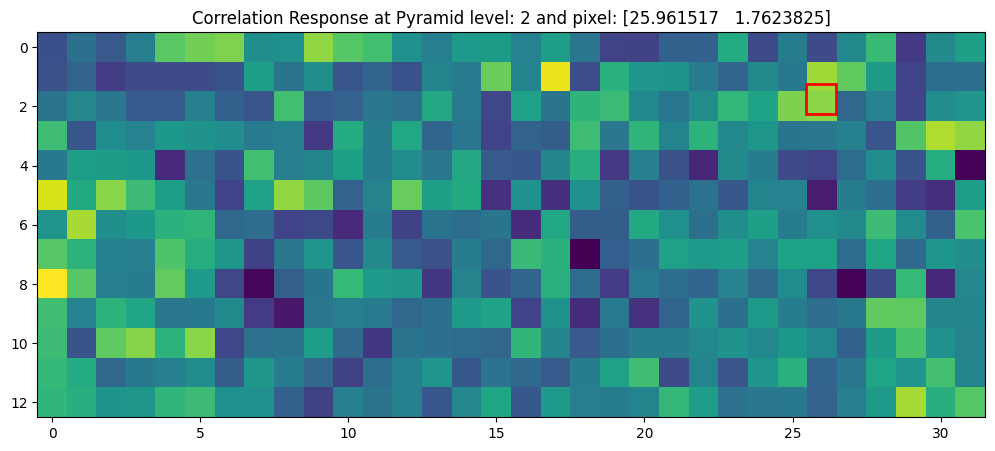

In [ ]:
import matplotlib.patches as patches
_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(corr_response);
ax.set_title(f"Correlation Response at Pyramid level: {i} and pixel: {pixel_loc}");

# mark I2 pixel under test
rect = patches.Rectangle(pixel_loc - 0.5, 1, 1, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show();

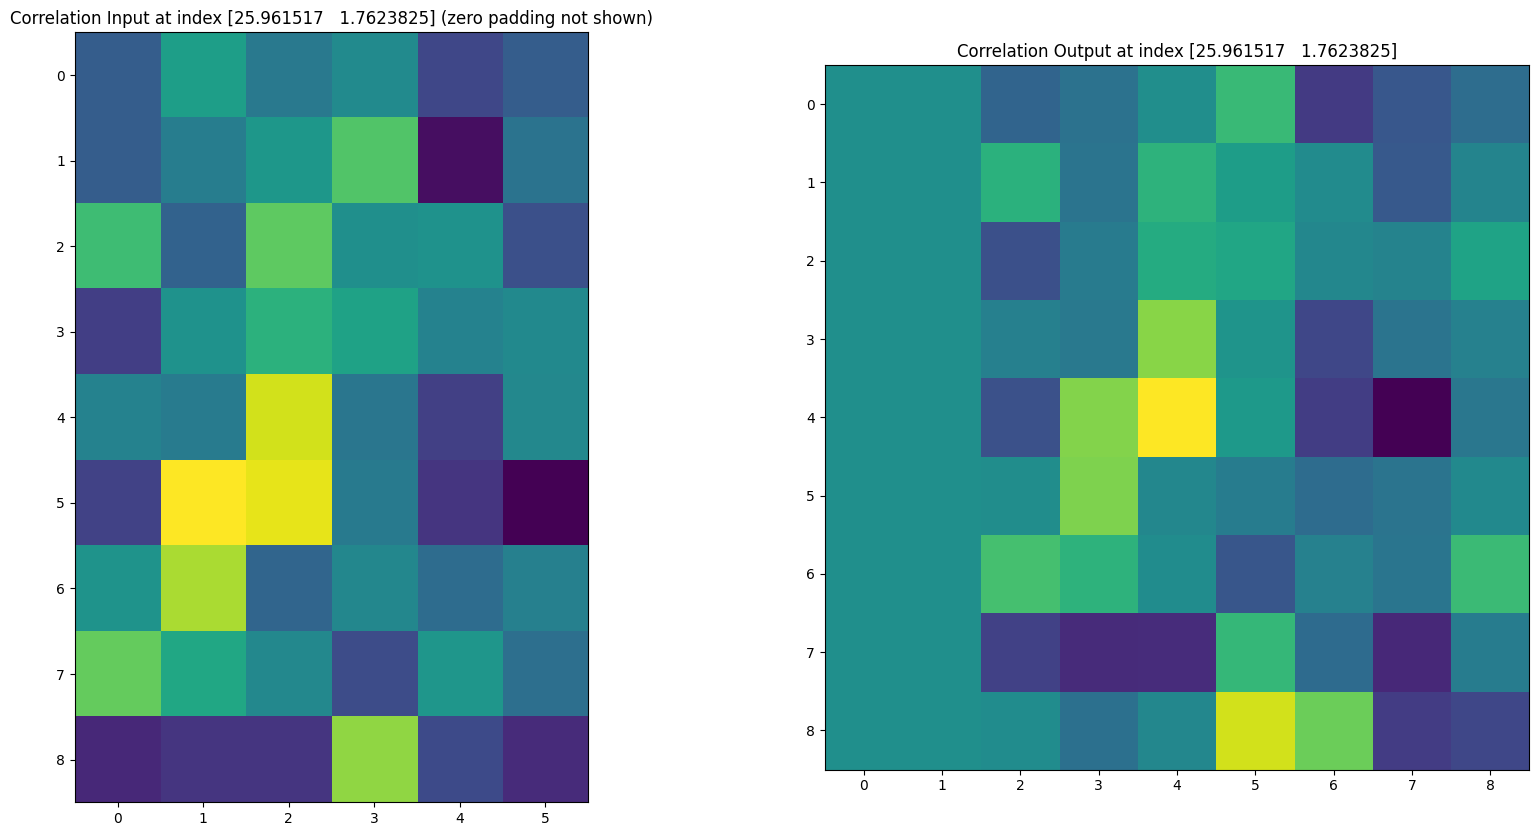

In [ ]:
_, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

# ax0.imshow(_corr[idx, 0, 19:28, 52:61].detach().cpu().numpy().T)
# ax0.set_title(f"Correlation Input at index {idx}")
# ax1.imshow(corr[idx, 0, :, :].detach().cpu().numpy())
# ax1.set_title(f"Correlation Output at index {idx}");

# ensure orientations are consistentidx
# input_corr = _corr[idx, 0, yi0:yi1, xi0:xi1].detach().cpu().numpy()
# output_corr = corr[idx, 0, :, :].detach().cpu().numpy().T

input_corr = _corr[idx, 0, yi0:yi1, xi0:xi1].detach().cpu().numpy().T
output_corr = corr[idx, 0, :, :].detach().cpu().numpy()

ax0.imshow(input_corr)
ax0.set_title(f"Correlation Input at index {pixel_loc} (zero padding not shown)")
ax1.imshow(output_corr)
ax1.set_title(f"Correlation Output at index {pixel_loc}");